# Demonstration of reinforcement learning

Code for this notebook is written after the excellent description by Andrej's Karpathy (http://karpathy.github.io/2016/05/31/rl/).

## Reinforcement learning introduction

So far we have analyzed two kinds of learning:
1. In supervised learning, our task was to learn an input-output relation. We always knew what the correct answer was, and we trained our models to simply return the correct answer.
2. In unsupervised learning our task was to describe the data, or to detect the structure of the data.

This notebook introduces a third kind of learning: reinforcement. Our network will implement and *agent* tasked with solving a task in an *environment*. In our case the agent will play the game of Pong against the built-in Atari AI player. Even though the agent will have to make a decision to move the paddle up or down at each step, it will only get a sparse *reward* signal of $+1$ whenever it wins a game or $-1$ whenever it loses one.

We start to see the main problem of reinforcement learning: we don't know which moves were good or bad. Instead we only know that collectively something good or bad has happened after many moves.

The algorithm we will develop in this notebook will implement a policy, i.e. a function from game screens into probabilities assigned by the agent to its actions. In particular the game will follow a loop:

```python
    states = [env.reset()]  # get the initial state (game screen)
    done = False
    while not done:
        # 1. Get the probability of an action possibly using
        # all previous states, then sample the action.
        action_probs = policy(states, Theta)
        action = sample(action_probs)
        
        # 2. Run the environment for one step. Record the new state
        # (game screen), the reward (usually 0) and the done flag.
        state_new, reward, done = env.step(action)
        states.append(state_new)
```

Our goal is to train the `policy` network to choose actions that will maximize the rewards we obtain from the environment. 
Some basic terminology:

* Let $\pi(A|S; \Theta)$ be our policy, that is parameterized by $\Theta$ and in state $S$ assigns probability to action $A$.
* A *rollout* $\tau$ is a sequence of state-action-rewards: $\tau = [s_0, a_0, r_0, s_1, a_1, r_1, \ldots]$. The rollouts are sampled based on the implemented policy (which chooses the actions) and based on the environment (which chooses the next states and can e.g. also use a random number generator).
* The reward of a rollout is a sum of all rewards obtained during the rollout: $r(\tau) = \sum_t=0^T r_t$

Of course, our goal is to learn a policy that when executed will maximize the expected reward of rollouts!

## Policy optimization

To solve the reinforcement learning task we must find a policy that optimizes the expected value of rewards obtained during rollouts using this policy. Rollouts depend on the policy's parameters $\Theta$. Thus we have a function to maximize! But how do we optimize it over $\Theta$?

We could try some generic function optimization methods, such as genetic programming to find a good $\Theta$. However, maybe we can somehow estimate the gradient of the policy with respect to $\Theta$ and more a somewhat more coordinated changes to it? This approach will be called *policy gradients* and below we will introduce a particularly simple variant of it called *REINFORCE* (http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf). We will first observe that:

$$
\begin{split}
\nabla_\Theta \mathbb{E}_\tau\left[r(\tau)\right] &= \nabla_\Theta \int p(\tau) r(\tau) d\tau =  \\
&= \int \left( \nabla_\Theta p(\tau) \right) r(\tau) d\tau = \text{    ($r(\tau)$ does not depend on $\Theta$)} \\
&= \int \left( \nabla_\Theta p(\tau) \right) \frac{p(\tau)}{p(\tau)} r(\tau) d\tau = \\
&= \int p(\tau) \left( \nabla_\Theta \log p(\tau) \right) r(\tau) d\tau = \\
&= \mathbb{E}_\tau\left[\left( \nabla_\Theta \log p(\tau) \right)r(\tau)\right]
\end{split}
$$

This means that we can estimate policy gradients by sampling a few rollouts, observing their rewards, and maximizing the likelihood of the best rollouts! In other words, the agent will randomly act in the environment, trying to repeat actions that led to large rewards (increasing their probability) and trying to avoid actions that led to low rewards!

Of course the agent will be very confused while learning: if a good action was followed by many bad actions, the agent will try to avoid it, and likewise a few bad actions in a sequence of good ones will be encouraged. But when averaged over many rollouts, the good actions will be more reinforced and the agent will learn to prefer them.

Technically, the gradient found the basic policy gradient method is unbiased (if we estimate it using many rollouts, we will get the real one), but has high variance (we may need many many rollouts to get the true gradient). One simple and powerful technique to reduce the variance of the gradient, while not introducing a bias is to subtract a baseline score:

### Baselines

$$
\mathbb{E}_\tau\left[\left( \nabla_\Theta \log p(\tau) \right)r(\tau)\right] = 
\mathbb{E}_\tau\left[\left( \nabla_\Theta \log p(\tau) \right)(r(\tau) - b)\right]
$$

The proof is easy. Intuitively, to appreciate the baseline subtraction think of a game in which you always get a positive reward, albeit sometimes it is smaller and sometimes it is larger. With many rewards, you will see that some actions are better. However, at the beginning all actions will seem to be OK (all yield positive rewards after all!). The baseline (think of it as of a mean reward) subtraction solves this problem: the smaller rewards will be negative.

### Introducing gradient bias to lower its variance

We can also change the formula for the gradient to introduce a bias (meaning that we will not get the true gradient even after averaging over may rollouts), but lower the variance (after averaging only a few rollouts we will get a good estimation of the gradient). Among the tricks we can do are:
1. discounting the rewards - making steps that immediately lead to a good reward better, by dirtributing a little bit of reward at step 
2. normalizing the rewards the standard deviation and mean of the rewards, essentially assuming that half of the moves performed are good, and half are bad.

Informally, we will compute the policy gradient my multiplying the log-probability of an action by our estimate of its *advantage*, i.e. our estimate of how much this action turned out to be better than expected. Our biased policy gradient will be computed using the formula:

$$
\begin{split}
    \nabla_\Theta \mathbb{E}_\tau\left[r(\tau)\right]  &= 
    \mathbb{E}_\tau\left[\left( \nabla_\Theta \log p(\tau) \right)r(\tau)\right] = \\
    &= \mathbb{E}_\tau\left[\left( \sum_t^T \nabla_\Theta \log \pi(a_t|s_t, \Theta) \right)r(\tau)\right] \approx \\
    &\approx \mathbb{E}_\tau\left[\sum_t^T \left( \nabla_\Theta \log \pi(a_t|s_t, \Theta) A_t \right)\right],
\end{split}
$$
where $A_t$ is our estimated advantage of move $t$ in the rollout $\tau$.

### Pong specific hacks

A rollout of the Atari Pong environment lasts until one player wins 21 games. Winning a game yields a reward of $+1$ and loosing a game of $-1$. Thus, the total reward for a rollout lies between $-21$ (all games lost) and $21$ (all games won). 

We know that the state is reset in each game, and thus it makes little sense to carry the reward form one game to the next. Also, the most important are the moves that are close to the end of a game (simply passing the ball multiple times is neutral). Thus we will use the following strategy to discount rewards:

If a game lasted for $M$ moves and after the $M$-th move the reward was $r_M\in \pm1$, the discounted reward for move $t$ will be $r_M \gamma ^{M-t}$. This distributes more of the reward to the moves that happened right before the game ending move $M$.

In the code below, the advantage estimation is computed in the function `estimate_advantage`. Please note, that better advantage estimations scheme exist (we can e.g. use learn an estimate of rewards following a state, which is called a *value function*).

## Notes on the `Tensorflow` implementation

The policy is implemented using a small convolutional network similar to the one described in https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf. However, network training is not as straight forward as in the supervised learning case. The basic policy gradient algorithm requires us to:
1. execute a rollout using a current policy
2. observe all rewards and estimate the advantages
3. compute the loss over all steps of the rollout and take its derivative
4. possibly aggregate the derivatives over a few rollouts
5. update the parameters $\Theta$

In the code we use a `while_loop` to execute a single rollout. Tensorflow is smart enough to remember the activations and inputs to the policy network that will be later used for derivative computation. We then estimate the advantages and compute gradients. Since the majority of time is spent in the Atari emulator, the gradients for a minibatch of rollouts are computed in many threads and aggregated in accumulator variables. Finally, an update using the Adam learning rule is performed.

In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
from glob import glob

import threading

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from common import plotting

In [4]:
from IPython.display import HTML

In [5]:
import gym
import gym.wrappers

In [6]:
#WORKDIR="./15-rl-workdir/convnn/"
WORKDIR="./15-rl-workdir/vanillann/"

In [7]:
#!rm -Rf $WORKDIR/*

In [8]:
# Record a movie of a random agent

env = gym.make("Pong-v0")
env = gym.wrappers.Monitor(env, WORKDIR + "vid_random", force=True)

env.reset()

steps = []
while True:
    step_img, reward, done, extra = env.step(env.action_space.sample())
    steps.append((step_img, reward))
    if done:
        break
        
env.close()

INFO:gym.envs.registration:Making new env: Pong-v0
[2018-01-30 14:35:10,993] Making new env: Pong-v0
INFO:gym.wrappers.monitoring:Creating monitor directory ./15-rl-workdir/vanillann/vid_random
[2018-01-30 14:35:11,884] Creating monitor directory ./15-rl-workdir/vanillann/vid_random
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /pio/lscratch/1/jch/private/Dropbox/work/II/fall17/nnets17/lectures/15-rl-workdir/vanillann/vid_random/openaigym.video.0.15923.video000000.mp4
[2018-01-30 14:35:11,895] Starting new video recorder writing to /pio/lscratch/1/jch/private/Dropbox/work/II/fall17/nnets17/lectures/15-rl-workdir/vanillann/vid_random/openaigym.video.0.15923.video000000.mp4
INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/pio/lscratch/1/jch/private/Dropbox/work/II/fall17/nnets17/lectures/15-rl-workdir/vanillann/vid_random')
[2018-01-30 14:35:12,895] Finished writing results. You can upload them to th

In [9]:
def play_videos():
    video_template = """
    %s <br>
    <video width="320" height="240" controls>
      <source src="%s" type="video/mp4">
      Your browser does not support the video tag.
    </video><br>
    """

    videos = []

    for f in glob(WORKDIR + "*/*.mp4"):
        videos.append(video_template % (f[len(WORKDIR):],f))

    return HTML(''.join(videos))

play_videos()

In [10]:
def affine_layer(X, num_hidden, activation=None, name=None):
    name = name or "affine_layer"
    with tf.variable_scope(None, default_name=name):
        W = tf.get_variable('W', (X.shape[1].value, num_hidden), 'float32',
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('b', (1, num_hidden), 'float32',
                            initializer=tf.zeros_initializer())
        Y = tf.matmul(X, W) + b
        if activation:
            Y = activation(Y)
        return Y

def conv2d_layer(X, filter_shape, num_filters, stride=1, activation=None, name=None):
    name = name or "conv2d_layer"
    num_channels = X.shape[3].value
    with tf.variable_scope(None, default_name=name):
        F = tf.get_variable('F', (filter_shape[0], filter_shape[1], num_channels, num_filters), 'float32',
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())
        Y = tf.nn.conv2d(X, F, (1, stride, stride, 1), padding='SAME')
        
        # Use a separate bias for each filter location!
        b = tf.get_variable('b', [1] + Y.shape.as_list()[1:], 'float32',
                            initializer=tf.zeros_initializer())
        Y += b
        if activation:
            Y = activation(Y)
        return Y

In [11]:
tf.reset_default_graph()
envs = []

NWORKERS = 12
MAX_ROLLOUTS_IN_BATCH = 100

for i in range(NWORKERS):
    envs.append(gym.make("Pong-v0"))
    envs[-i].seed(i)

# Add space for a monitoring env
envs.append(None)

def preproc_state(state):
    """Normalize the screen (crop and binarize).
    """
    state = state[35:195:2, ::2]
    state = ((state[:,:,0] != 144) & (state[:,:,0] != 119)).astype('float32')
    return state


def env_step_fun(env_id, action):
    """Advance the environment by a few steps (repeat the action), record the reward.
    """
    FRAME_SKIPS = 1
    sum_reward = 0
    for i in range(FRAME_SKIPS):
        state, reward, done, _ = envs[env_id].step(action=2 if action else 3)
        sum_reward += reward
        if done:
            break
    return preproc_state(state), np.array(sum_reward, dtype='float32'), done


def conv_net(prev_state, cur_state):
    """The policy network. It takes two past screens and computes log(p(action=2)).
    
    Args:
        prev_state and cur_state: grayscale images of shape 80 x 80 pixels
    """
    with tf.variable_scope("network"):
        #input_ = tf.reshape(cur_state - prev_state, (1, 80*80))
        #hidden = tf.layers.dense(input_, 200, activation=tf.nn.relu, 
        #                         kernel_initializer=tf.contrib.layers.xavier_initializer())
        #action_logit = tf.layers.dense(hidden, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.reshape(cur_state - prev_state, (1, 80, 80, 1))
        x = conv2d_layer(x, (8, 8), 16, stride=4, activation=tf.nn.relu)
        x = conv2d_layer(x, (4, 4), 32, stride=2, activation=tf.nn.relu)
        x = tf.reshape(x, (1, -1))
        x = affine_layer(x, 256, activation=tf.nn.relu)
        action_logit = affine_layer(x, 1)
    return action_logit


def vanilla_net(prev_state, cur_state):
    """The policy network. It takes two past screens and computes log(p(action=2)).
    
    Args:
        prev_state and cur_state: grayscale images of shape 80 x 80 pixels
    """
    with tf.variable_scope("network"):
        input_ = tf.reshape(cur_state - prev_state, (1, 80*80))
        hidden = tf.layers.dense(input_, 200, activation=tf.nn.relu, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        action_logit = tf.layers.dense(hidden, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
    return action_logit

net = vanilla_net

def estimate_advantage(r, gamma=0.99):
    """Take 1D float array of rewards and compute discounted reward.
    
    This will introduce a bias in our gradients: we will train on more steps, 
    but we will introduce a systematic error in the gradient.
    """
    advantage = np.zeros_like(r)
    running_add = 0
    for t in xrange(r.size-1, -1, -1):
        if r[t] != 0:
            running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        advantage[t] = running_add
    advantage -= advantage.mean()
    advantage /= advantage.std()
    return advantage

env_id = tf.placeholder('int32', (), "env_id")
cur_state = tf.placeholder('float32', (80, 80), "cur_state")
prev_state = tf.zeros_like(cur_state)

states = tf.TensorArray('float32', size=2, dynamic_size=True, clear_after_read=False)
states = states.write(0, prev_state)
states = states.write(1, cur_state)

done = tf.constant(False)

rewards = tf.TensorArray('float32', size=0, dynamic_size=True)

action_logits = tf.TensorArray('float32', size=0, dynamic_size=True)
actions = tf.TensorArray('int32', size=0, dynamic_size=True)

def while_cond(step, done, *args):
    return tf.not_equal(done, True)

def while_body(step, done, states, rewards, action_logits, actions):
    prev_state = states.read(step)
    cur_state = states.read(step+1)
    
    
    action_logit = net(prev_state, cur_state)
    action_logits = action_logits.write(step, action_logit)
    
    action = tf.cast(tf.random_uniform(()) < tf.nn.sigmoid(action_logit), tf.int32)
    actions = actions.write(step, action)
    
    state, reward, done = tf.py_func(env_step_fun, [env_id, action], 
                                     [tf.float32, tf.float32, tf.bool])
    
    state.set_shape(cur_state.shape)
    reward.set_shape(())
    done.set_shape(())
    
    states = states.write(step+2, state)
    rewards = rewards.write(step, reward)
    
    return step + 1, done, states, rewards, action_logits, actions
    
(steps, done, states, rewards, action_logits,actions
) = tf.while_loop(while_cond, while_body, [0, False, states, rewards, action_logits, actions])

states = states.stack()
rewards = tf.reshape(rewards.stack(), (-1,))
actions = tf.reshape(actions.stack(), (-1,))
action_logits = tf.reshape(action_logits.stack(), (-1,))

estimated_advantage = tf.py_func(estimate_advantage, [rewards], tf.float32, stateful=False)
estimated_advantage.set_shape(rewards.shape)

action_neg_likelihood = tf.nn.sigmoid_cross_entropy_with_logits(logits=action_logits,
                                                                labels=tf.cast(actions, tf.float32))
loss = tf.reduce_sum(action_neg_likelihood * estimated_advantage)

accums = []
with tf.variable_scope('accums'):
    for var in tf.trainable_variables():
        accums.append(tf.get_variable(var.name.split(':')[0],
                                      var.get_shape(),
                                      var.dtype,
                                      tf.zeros_initializer(),
                                      trainable=False))
    reward_accum = tf.get_variable('rewards', (), tf.float32, tf.zeros_initializer(), trainable=False)
        
grads = tf.gradients(loss, tf.trainable_variables())

rollout_count = tf.Variable(0, name='rollout_count', trainable=False)

grad_count = tf.Variable(0, name='grad_count_count', trainable=False)

grad_update_op = tf.group(tf.assign_add(rollout_count, 1),
                          tf.assign_add(grad_count, 1),
                          tf.assign_add(reward_accum, tf.reduce_sum(rewards)),
                          *[tf.assign_add(a, g, use_locking=True) 
                            for a,g in zip(accums, grads)])

global_step = tf.Variable(0, name='global_step', trainable=False)

trainer = tf.train.AdamOptimizer()
train_op = trainer.apply_gradients(zip([a / tf.cast(grad_count, 'float32') for a in accums], 
                                       tf.trainable_variables()), global_step)

reset_accums_op = tf.group(tf.assign(grad_count, 0),
                           tf.assign(reward_accum, 0.0),
                           *[tf.assign(a, tf.zeros_like(a)) for a in accums])

#train_op = tf.group(reset_accums_op)

INFO:gym.envs.registration:Making new env: Pong-v0
[2018-01-30 14:35:18,552] Making new env: Pong-v0
INFO:gym.envs.registration:Making new env: Pong-v0
[2018-01-30 14:35:18,946] Making new env: Pong-v0
INFO:gym.envs.registration:Making new env: Pong-v0
[2018-01-30 14:35:19,312] Making new env: Pong-v0
INFO:gym.envs.registration:Making new env: Pong-v0
[2018-01-30 14:35:19,701] Making new env: Pong-v0
INFO:gym.envs.registration:Making new env: Pong-v0
[2018-01-30 14:35:20,064] Making new env: Pong-v0
INFO:gym.envs.registration:Making new env: Pong-v0
[2018-01-30 14:35:20,431] Making new env: Pong-v0
INFO:gym.envs.registration:Making new env: Pong-v0
[2018-01-30 14:35:20,847] Making new env: Pong-v0
INFO:gym.envs.registration:Making new env: Pong-v0
[2018-01-30 14:35:21,259] Making new env: Pong-v0
INFO:gym.envs.registration:Making new env: Pong-v0
[2018-01-30 14:35:21,647] Making new env: Pong-v0
INFO:gym.envs.registration:Making new env: Pong-v0
[2018-01-30 14:35:21,996] Making new env

In [12]:
int_placeholder = tf.placeholder('int32', (), 'int_placeholder')
work_queue = tf.FIFOQueue(MAX_ROLLOUTS_IN_BATCH, [tf.int32], shapes=[()])
work_enqueue = work_queue.enqueue(int_placeholder)
work_deque_one = work_queue.dequeue()
work_deque_all = work_queue.dequeue_many(int_placeholder)

done_queue = tf.FIFOQueue(MAX_ROLLOUTS_IN_BATCH, [tf.int32], shapes=[()])
done_enqueue = done_queue.enqueue(int_placeholder)
done_deque_one = done_queue.dequeue()
done_deque_all = done_queue.dequeue_many(int_placeholder)


In [13]:
saver = tf.train.Saver(tf.global_variables(), keep_checkpoint_every_n_hours=1)

In [14]:
sess = tf.InteractiveSession()
if os.path.exists(WORKDIR + "checkpoint"):
    latest_ckpt = tf.train.latest_checkpoint(os.path.dirname(WORKDIR))
    print("Restoring from:", latest_ckpt)
    saver.restore(sess, latest_ckpt)
    # saver.recover_last_checkpoints(WORKDIR + "checkpoint")
else:
    sess.run(tf.global_variables_initializer())

Restoring from: ./15-rl-workdir/vanillann/tf_save-1540
INFO:tensorflow:Restoring parameters from ./15-rl-workdir/vanillann/tf_save-1540


INFO:tensorflow:Restoring parameters from ./15-rl-workdir/vanillann/tf_save-1540
[2018-01-30 14:35:26,253] Restoring parameters from ./15-rl-workdir/vanillann/tf_save-1540


In [15]:
def env_simulator(env_id_v):
    # print ("Starting env_id %d" %(env_id_v,))
    while True:
        job = sess.run(work_deque_one)
        # print ("Running env_id %d job %d" %(env_id_v, job,))
        sess.run([grad_update_op], 
                 feed_dict={cur_state: preproc_state(envs[env_id_v].reset()),
                            env_id: env_id_v})
        sess.run([done_enqueue], feed_dict={int_placeholder: job})
    
threads = []
for i in range(NWORKERS):
    thread = threading.Thread(target=env_simulator, args=(i,))
    threads.append(thread)
    thread.start()

In [ ]:
#
# This notebook cell runs the training. If you restore your model from a checkpoint, you don't need to run it.
#

BATCH_SIZE = 10

# Reset the accumulators, which can be non-zero after a resumed training
sess.run(reset_accums_op)

while True:
    # accumulate gradients over a minibatch of inputs
    for i in range(BATCH_SIZE):
        sess.run(work_enqueue, feed_dict={int_placeholder: i})
    dequed_tasks = sess.run(done_deque_all, feed_dict={int_placeholder: BATCH_SIZE})
    
    # read the statistics
    grad_count_v, reward_accum_v, global_step_v, rollout_count_v = sess.run(
        [grad_count, reward_accum, global_step, rollout_count])

    if grad_count_v != BATCH_SIZE:
        print ("Weirdo: grad_count_v=%d and BATCH_SIZE=%d, dequed=%s" % 
               (grad_count_v, BATCH_SIZE, set(dequed_tasks)))
        sess.run(reset_accums_op)
        continue
            
    print ("After %d steps (%d rollouts) the mean reward is %f" % 
           (global_step_v, rollout_count_v, reward_accum_v / grad_count_v))
    
    sess.run(train_op)
    sess.run(reset_accums_op)
    
    if (global_step_v % 10) == 0:
        save_path = saver.save(sess, WORKDIR + "/tf_save", global_step=global_step_v)
        print ("Saved to:", save_path)

In [16]:
# Play a game and record a video!

envs[-1] = gym.wrappers.Monitor(gym.make("Pong-v0"), WORKDIR + "/trained", force=True)
env_monitor = len(envs) - 1
sess.run(rewards, {cur_state: preproc_state(envs[env_monitor].reset()),
                   env_id: env_monitor})
envs[-1].close()

INFO:gym.envs.registration:Making new env: Pong-v0
[2018-01-30 14:35:37,509] Making new env: Pong-v0
INFO:gym.wrappers.monitoring:Creating monitor directory ./15-rl-workdir/vanillann//trained
[2018-01-30 14:35:37,779] Creating monitor directory ./15-rl-workdir/vanillann//trained
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /pio/lscratch/1/jch/private/Dropbox/work/II/fall17/nnets17/lectures/15-rl-workdir/vanillann/trained/openaigym.video.1.15923.video000000.mp4
[2018-01-30 14:35:37,790] Starting new video recorder writing to /pio/lscratch/1/jch/private/Dropbox/work/II/fall17/nnets17/lectures/15-rl-workdir/vanillann/trained/openaigym.video.1.15923.video000000.mp4
INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/pio/lscratch/1/jch/private/Dropbox/work/II/fall17/nnets17/lectures/15-rl-workdir/vanillann/trained')
[2018-01-30 14:35:50,186] Finished writing results. You can upload them to the scoreboard 

In [17]:
play_videos()

In [18]:
w0, = sess.run([v for v in tf.trainable_variables() if v.name == 'network/dense/kernel:0'])

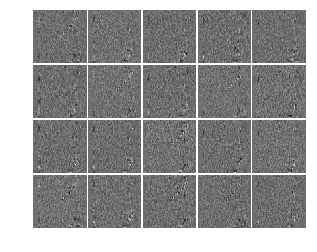

In [19]:
plotting.plot_mat(w0.T.reshape(-1, 1, 80, 80)[:20], scaleIndividual=False, cmap='gray')